# Feature Importance via Permutation Testing (regression)
**Dr. Dave Wanik - OPIM 5512: Data Science Using Python - University of Connecticut**

---------------------------------

Our model fit on Boston Housing and we got results - now what?! Which variables contributed most to the model's performance?

# What is feature importance?
[From the documentation...](https://scikit-learn.org/stable/modules/permutation_importance.html)

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled 1. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

The permutation_importance function calculates the feature importance of estimators for a given dataset. The n_repeats parameter sets the number of times a feature is randomly shuffled and returns a sample of feature importances.

## Getting started
Import modules, mount Drive, read in the data, check data types and missing values. You may also do some light EDA prior to modeling.

Notice how we are using the same functions over and over again... it really is like following a recipe.


In [ ]:
# import modules we need for EDA and wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# these functions are useful for splitting and normalization
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import train_test_split

# import other functions we'll need for regression modeling
from sklearn.linear_model import LinearRegression # LR
from sklearn.tree import DecisionTreeRegressor # DTR
from sklearn.ensemble import RandomForestRegressor # RFR
from sklearn.ensemble import GradientBoostingRegressor #GBR

# regression error metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# permutation testing
from sklearn.inspection import permutation_importance

In [ ]:
# Load dataset
# we will use Gdown to load our Boston Housing dataset
# https://drive.google.com/file/d/1a0aNGSFWB-pf5ut1NsjE5ECIsbHHoAwI/view?usp=sharing
!gdown --id 1a0aNGSFWB-pf5ut1NsjE5ECIsbHHoAwI

# look left! it downloaded a local copy of 'BostonHousing.csv'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1a0aNGSFWB-pf5ut1NsjE5ECIsbHHoAwI
To: /content/BostonHousing.csv
100% 35.2k/35.2k [00:00<00:00, 36.7MB/s]


In [ ]:
df = pd.read_csv('BostonHousing.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
# data type, shape and columns

print("This is the shape :\n", df.shape, '\n') # escape characters are fun! \n adds a return line
print("These are the column names: \n", df.columns, '\n') # helps keep things nice and clean
print("These are the data types: \n", df.dtypes)

print("\nThis is the head:") # see how I can pop that \n anywhere?
df.head()   # also note how much stuff I have pasted in ONE CELL...
            # now you are cooking with gas!

# the head confirms to use that the valid column is some type of time/date stamp
# we need to stop what we are doing and take care of this NOW!

This is the shape :
 (506, 14) 

These are the column names: 
 Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat', 'medv'],
      dtype='object') 

These are the data types: 
 crim       float64
zn         float64
indus      float64
chas         int64
nox        float64
rm         float64
age        float64
dis        float64
rad          int64
tax          int64
ptratio    float64
b          float64
lstat      float64
medv       float64
dtype: object

This is the head:


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [ ]:
# here's another cool way to get a lot of this info AND MORE
df.info() # gives you missing values report too - this is nice complete data

# data types, shape, missing values per columm.... pandas rocks...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


## Data splitting
Subset your data into X features and Y target variable for modeling. Convert X and Y to numpy arrays. Then use train_test_split for data splitting (80/20 is very common); don't forget random seed and shuffle.

In [ ]:
# the target variable is Y
# we know that this is 'medv'
Y = df['medv']
print(Y.shape) # a single column with 506 rows

(506,)


In [ ]:
# everything else is X
# so just drop 'medv' and you are done
X = df.drop('medv', axis=1)
print(X.shape) # note that we have gone from 14 to 13 columns, this is good! 506 rows.

(506, 13)


### *Sneaky Column Subset...*
Uncomment this cell at the very end and re-run the script, and you will see how the variable importance changes.

In [ ]:
# commented out for now, but later, let's try re-running
# by only using a few columns (from feature importance plots)
X = df[['lstat', 'crim', 'dis', 'rad']]
X.shape # only 4 columns

(506, 4)

In [ ]:
# now, split the data in ONE LINE OF CODE
# notice how we are assigning four different variables at once
# this makes it really clean

# be careful of capital vs. lowercase X and Y, you might get an error...
# notice the 80/20 split we perform

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)

In [ ]:
# check your work - does the shape match what you think it should be?
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(404, 4) (102, 4) (404,) (102,)


In [ ]:
# convert these all to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## Min/Max Scaling
This will ensure all of your X data is between 0 (min) and 1 (max). You will use fit_transform() on the train data first, then fit on the test data. If you don't do this step after splitting, you will have data leakage.

Only scale the X data, not the Y data!

Do yourself a favor and just overwrite X_train and X_test when standardizing, as I do below. Min/max scaling requires that the data are numpy arrays and all numeric data.


**Like this example:**
```
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```


In [ ]:
# you probably have already imported the MinMaxScale at the top of your script
# you should convert to numpy array before scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# if you wanted to run summary stats on these to check the range,
# you would need to convert to a pandas dataframe.
tmp = pd.DataFrame(X_train)
tmp.describe() # notice how all the max values are 1, all min values are 0.

,0,1,2,3
count,404.000000,404.000000,404.000000,404.000000
mean,0.296009,0.040465,0.243577,0.363323
std,0.196203,0.099757,0.193802,0.373466
min,0.000000,0.000000,0.000000,0.000000
25%,0.139142,0.000814,0.087140,0.130435
50%,0.253725,0.002836,0.186066,0.173913
75%,0.404042,0.035900,0.388400,0.478261
max,1.000000,1.000000,1.000000,1.000000


## Fit The Models
Fit the model and make new variables to save your train and test predictions. Make sure you are using the appropriate regression or classification model.

Notice how we're using the same training data and test data for each model - this is critical!

Also note that in many StackOverflow examples, folks don't use 'DTR' or 'LR' as variable names for their models - instead, they often use 'clf' which stands for classifier. Helps you abstract what's going on.

### Linear Regression

In [ ]:
# make a variable to store the general model
LR = LinearRegression()
# fit the model - one line of code
LR = LR.fit(X_train, y_train)

In [ ]:
# store the predictions
train_preds_LR = LR.predict(X_train)
test_preds_LR = LR.predict(X_test)

### DTR

Check out the model documentation:

**DTR Model Documentation:** https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html


Some extra content to think about...

**Link:** https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

**Link:** https://scikit-learn.org/stable/modules/tree.html

In [ ]:
# make a variable to store the general model
# you can accept all of the defaults...
# DTR = DecisionTreeRegressor()
# or start to 'tinker' :) this is called hyperparameter tuning
DTR = DecisionTreeRegressor(min_samples_split=15) # make this bigger and the tree will shrink!

# fit the model - one line of code
DTR = DTR.fit(X_train, y_train)

In [ ]:
# store the predictions
train_preds_DTR = DTR.predict(X_train)
test_preds_DTR = DTR.predict(X_test)

In [ ]:
# # show the tree
# # link: https://www.datacamp.com/community/tutorials/decision-tree-classification-python
# from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO
# from IPython.display import Image
# import pydotplus

# dot_data = StringIO()
# export_graphviz(DTR, out_file=dot_data,
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# Image(graph.create_png())

# # hard to see, but that's OK!
# # we will learn about partial depenence
# # and feature importance with is way easier to see than this

# # for now, just appreciate how awesome this looks!
# # double click and you can see

### RFR
Random Forest Regressor

In [ ]:
# make a variable to store the general model
# you can accept all of the defaults...
RFR = RandomForestRegressor()
# or start to 'tinker' :) this is called hyperparameter tuning

# fit the model - one line of code
RFR = RFR.fit(X_train, y_train)

In [ ]:
# store the predictions
train_preds_RFR = RFR.predict(X_train)
test_preds_RFR = RFR.predict(X_test)

## Evaluate the Model
Look at the appropriate error metrics depending on the problem you are solving.

For a regression problem, look at the R2, MAE and MSE; then make a scatterplot of actual vs. predicted values with nice labels and titles.

For a classification problem, create the classification report (gives a confusion matrix and useful metrics in one line of code).

See how we are just tacking on a suffix like '_LR' or '_DTR' on the end of things? Keep your code clean and you can just copy paste. Same stuff as before, but we need to be organized since we are introducing more models.

### R2
Out of all of these, random forest is the most believable! Did not memorize the training data and has consistent results between train and test results. In practice - we only really care about the test results.

In [ ]:
# this is a regression problem, and there are three metrics to look at.
# 1) R2 value - for Linear Regression
print("This is train R2 (LR):", r2_score(y_train, train_preds_LR)) # train
print("This is test R2 (LR):", r2_score(y_test, test_preds_LR)) # test

# 1) R2 value - for Decision Tree Regression
print("This is train R2 (DTR):", r2_score(y_train, train_preds_DTR)) # train
print("This is test R2 (DTR):", r2_score(y_test, test_preds_DTR)) # test

# 1) R2 value - for Random Forest Regression
print("This is train R2 (RFR):", r2_score(y_train, train_preds_RFR)) # train
print("This is test R2 (RFR):", r2_score(y_test, test_preds_RFR)) # test

This is train R2 (LR): 0.5793582648454925
This is test R2 (LR): 0.5168252351755318
This is train R2 (DTR): 0.8793610673862026
This is test R2 (DTR): 0.6969059363908625
This is train R2 (RFR): 0.9622807420095582
This is test R2 (RFR): 0.7607907042092698


### MAE
Again, RFR is the champ here - best test results!

In [ ]:
# 2) mae - for Linear Regression
trainMAE_LR = mean_absolute_error(y_train, train_preds_LR)
print("This is trainMAE (LR):", trainMAE_LR) # train
testMAE_LR = mean_absolute_error(y_test, test_preds_LR)
print("This is testMAE (LR):", testMAE_LR) # test

# 2) mae - for DT Regression
trainMAE_DTR = mean_absolute_error(y_train, train_preds_DTR)
print("This is trainMAE (DTR):", trainMAE_DTR) # train
testMAE_DTR = mean_absolute_error(y_test, test_preds_DTR)
print("This is testMAE (DTR):", testMAE_DTR) # test

# 2) mae - for RF Regression
trainMAE_RFR = mean_absolute_error(y_train, train_preds_RFR)
print("This is trainMAE (RFR):", trainMAE_RFR) # train
testMAE_RFR = mean_absolute_error(y_test, test_preds_RFR)
print("This is testMAE (RFR):", testMAE_RFR) # test

This is trainMAE (LR): 4.512065171722855
This is testMAE (LR): 4.362636341107396
This is trainMAE (DTR): 2.0859996851333484
This is testMAE (DTR): 3.3236183968536923
This is trainMAE (RFR): 1.2528613861386126
This is testMAE (RFR): 2.9373529411764707


### MSE
If you see an MSE of 0, this means a perfect prediction - this should NEVER happen... there should always be at least a little bit of error in your train results, otherwise you are OVERFITTING. You need to play with the hyperparameters (we will do this in future weeks).

In [ ]:
# 3) mse
trainMSE_LR = mean_squared_error(y_train, train_preds_LR)
print("This is trainMSE (LR):", trainMSE_LR)
testMSE_LR = mean_squared_error(y_test, test_preds_LR)
print("This is testMSE (LR):", testMSE_LR)

# 3) mse
trainMSE_DTR = mean_squared_error(y_train, train_preds_DTR)
print("This is trainMSE (DTR):", trainMSE_DTR)
testMSE_DTR = mean_squared_error(y_test, test_preds_DTR)
print("This is testMSE (DTR):", testMSE_DTR)

# 3) mse
trainMSE_RFR = mean_squared_error(y_train, train_preds_RFR)
print("This is trainMSE (RFR):", trainMSE_RFR)
testMSE_RFR = mean_squared_error(y_test, test_preds_RFR)
print("This is testMSE (RFR):", testMSE_RFR)

This is trainMSE (LR): 36.542579327073504
This is testMSE (LR): 35.43303343217759
This is trainMSE (DTR): 10.480314710935378
This is testMSE (DTR): 22.22703433789362
This is trainMSE (RFR): 3.2768003316831664
This is testMSE (RFR): 17.542122627450965


## Sub-Plots
Way cleaner! Try doing the plots side-by-side.

### LR Results

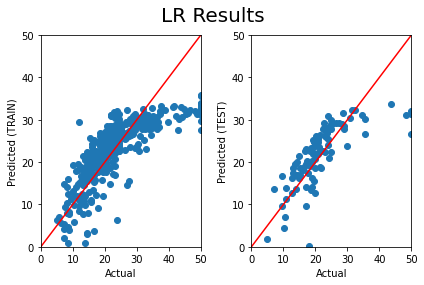

In [ ]:
# specify the dimensions
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# fig limits


# add a main title across top
fig.suptitle("LR Results", fontsize=20)

# this makes the individual subplots
axes[0].scatter(x=y_train, y=train_preds_LR) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted (TRAIN)",  fontsize=10)
# set plot limits
axes[0].set_xlim(0,50)
axes[0].set_ylim(0,50)
# add 45 degree line to left panel
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')


axes[1].scatter(x=y_test, y=test_preds_LR) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted (TEST)",  fontsize=10)
# set plot limits
axes[1].set_xlim(0,50)
axes[1].set_ylim(0,50)
# add 45 degree line to right panel
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# scooch it down
# link: https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot
fig.subplots_adjust(top=0.88)

# show the plot
plt.show()

### DTR Results

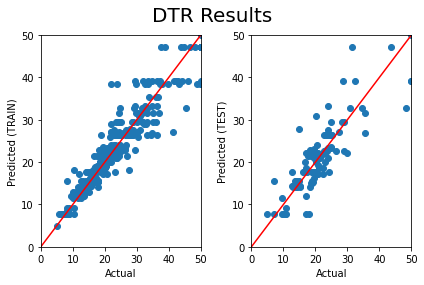

In [ ]:
# specify the dimensions
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# fig limits


# add a main title across top
fig.suptitle("DTR Results", fontsize=20)

# this makes the individual subplots
axes[0].scatter(x=y_train, y=train_preds_DTR) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted (TRAIN)",  fontsize=10)
# set plot limits
axes[0].set_xlim(0,50)
axes[0].set_ylim(0,50)
# add 45 degree line to left panel
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')


axes[1].scatter(x=y_test, y=test_preds_DTR) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted (TEST)",  fontsize=10)
# set plot limits
axes[1].set_xlim(0,50)
axes[1].set_ylim(0,50)
# add 45 degree line to right panel
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# scooch it down
# link: https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot
fig.subplots_adjust(top=0.88)

# show the plot
plt.show()

### RFR Results

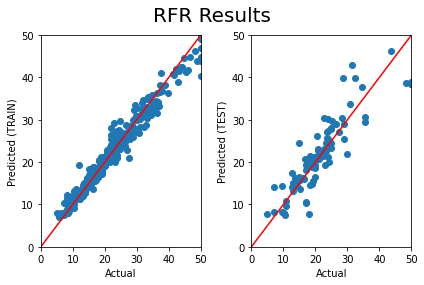

In [ ]:
# specify the dimensions
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# fig limits


# add a main title across top
fig.suptitle("RFR Results", fontsize=20)

# this makes the individual subplots
axes[0].scatter(x=y_train, y=train_preds_RFR) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted (TRAIN)",  fontsize=10)
# set plot limits
axes[0].set_xlim(0,50)
axes[0].set_ylim(0,50)
# add 45 degree line to left panel
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')


axes[1].scatter(x=y_test, y=test_preds_RFR) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted (TEST)",  fontsize=10)
# set plot limits
axes[1].set_xlim(0,50)
axes[1].set_ylim(0,50)
# add 45 degree line to right panel
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# scooch it down
# link: https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot
fig.subplots_adjust(top=0.88)

# show the plot
plt.show()

## Feature Importance
Each model has a different flavor - since each model treats the data differently, this means that different variables can affect the prediction!

Read this first: https://scikit-learn.org/stable/modules/permutation_importance.html

Feature importance is simply the reduction in score (R2 for regression, accuracy for classification) that occurs when we shuffle a column in the dataset. We are testing to see how our model is going to break!

### Image of shuffling one column
![shuffling one column](https://i.imgur.com/h17tMUU.png)

Imagine you built your model - we want to see if a column (predictor) really was important or not. If you shuffle one `X_test` column and leave all the rest, would you still get the same R2 value? If you get the same R2, that X_test column is not important! If your model TANKS and you get a terrible R2, well then that column must be pretty useful to the model. This is the essence of permutation testing.

### Some notes

We are going to use the TEST PARTITION (`X_test`) to see how shuffling the data one column at a time breaks the model. We repeat this N times so that we ensure our results aren't just a fluke.

The is an argument in the literature about where permutation is most useful - to me, it's to see once your model is built, how does it fall apart? The test partition answers this best because we want to know how our predictions would fall apart in the real-world (and test data is our dummy real-world data). However, there is nothing wrong with using the train partition.

Like most interpretable ML tools, permutation testing is a pretty good but imperfect tool.

* X axis is a relative scale of importance (higher is better!) and Y axis are the covariates.

* Note how these are sorted by the mean importance - I'm less interested in you memorizing this script, and more interested in you applying it. A key thing you can do is use feature importance for VARIABLE SELECTION. Choose the top N variables for modeling (if you have a bunch) and see if you can get a simpler result. Or choose some cut-off (importance > 0.05 or something like that).

* Also **note how modular this code is** - just change the model (change what clf is pointing to!)

### LR
Permutation testing for linear regression.

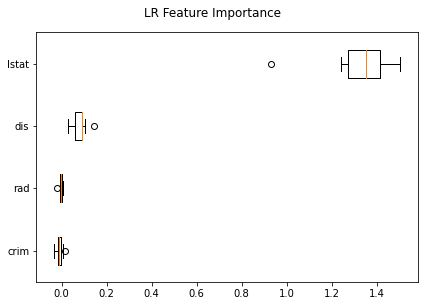

In [ ]:
# it even works for a linear regression!

# let's make this repeatable! all you need to do is assign
# a model object to clf!

clf = LR # don't forget to update title!

result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X.columns[perm_sorted_idx])
fig.suptitle('LR Feature Importance', y=1.05) # don't forget to update title!
fig.tight_layout()
plt.show()

### DTR
Permutation importance for DTR.

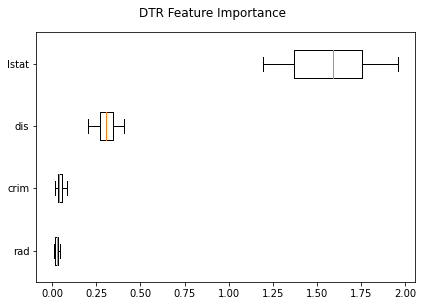

In [ ]:
from sklearn.inspection import permutation_importance

# let's make this repeatable! all you need to do is assign
# a model object to clf!

clf = DTR

result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X.columns[perm_sorted_idx])
fig.suptitle('DTR Feature Importance', y=1.05)
fig.tight_layout()
plt.show()

### RFR
Permutation results for random forest regressor.

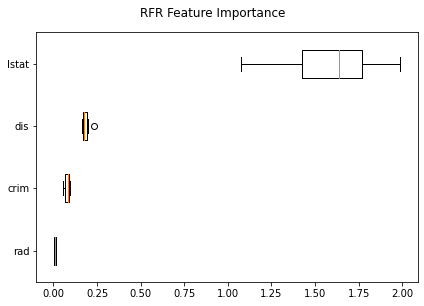

In [ ]:
from sklearn.inspection import permutation_importance

# let's make this repeatable! all you need to do is assign
# a model object to clf!

clf = RFR # just update the title!

result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X.columns[perm_sorted_idx])
fig.suptitle('RFR Feature Importance', y=1.05)
fig.tight_layout()
plt.show()

### Side By Side! As a boxplot.
Note how different variables are important - look at the Y axis!

Here is how to set a subplot title: https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/subplots_demo.html

`ax1.set_title('Axis 1')`

Remember, the scale of the X axis doesn't matter as much... you are looking for general trends.... which variables are the most important across your models?

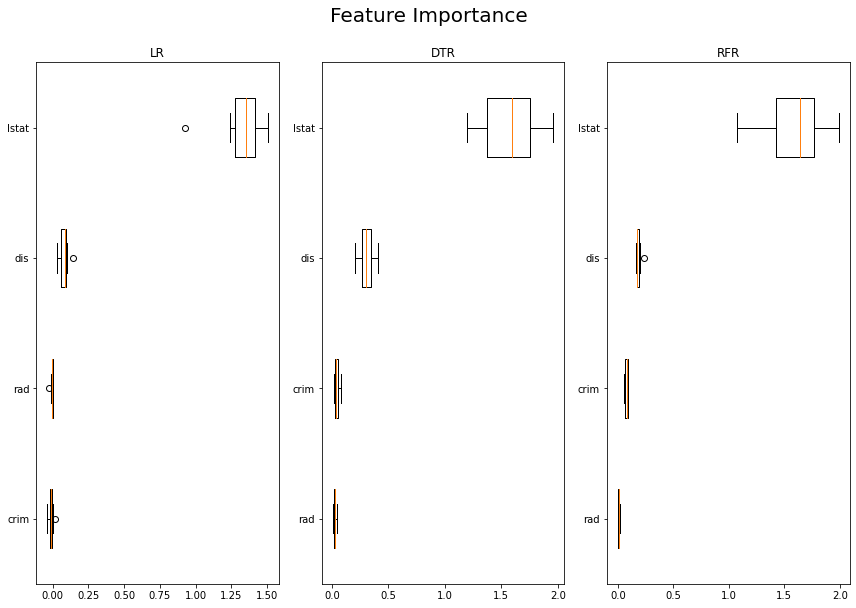

In [ ]:
# plot basics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8)) # 1 row, 3 columns
plt.suptitle('Feature Importance', y= 1.05, size = 20)
# LR
clf = LR # don't forget to update title!
result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X.columns[perm_sorted_idx])
ax1.set_title('LR')

# DTR
clf = DTR # don't forget to update title!
result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X.columns[perm_sorted_idx])
ax2.set_title('DTR')

# RFR
clf = RFR # don't forget to update title!
result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

ax3.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X.columns[perm_sorted_idx])
ax3.set_title('RFR')

fig.tight_layout()
plt.show()

# Done!
It looks like lstat, rm, crim, and dis are the four most important predictors. In the next script, let's see how each of these models treats the data with the aid of partial dependence plots!

Is this a perfect tool? No. But is it useful? Yes! This is a tool you can use to see what variables cause the most error in your model (caused by shuffling the values one at a time). If the shuffled data results in a worst prediction, you know that variable was 'important'. We repeat this N times to ensure our results aren't a fluke.

If you wanted to, go up and just keep lstat, rm, crim, and dis and see if you can get an accurate model! I've commented out some code you can activate to do this... you will find that you don't need all of those variables... just a subset!



# On Your Own
Why not try running a pipeline on your dataset, then try using permutation testing to evaluate which variables are most important?

# [optional] Permutation Importance and Correlated Predictors
When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important.

One way to handle this is to cluster features that are correlated and only keep one feature from each cluster. This strategy is explored in the following example: [Permutation Importance with Multicollinear or Correlated Features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py).

But in practice... it's probably fine! Importance is just ONE way to evalaute the model. It's very good but nothing is perfect.

# Resources
* https://scikit-learn.org/stable/modules/permutation_importance.html